In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import statsmodels.api as sm

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.api import VAR

In [260]:
#Reading in the Colorado SPrings GDP measured per month from 2006-2019 
co_unemp=pd.read_csv('../capstone/raw data/cos_unemp.csv')
cos_gdp=pd.read_csv('../capstone/raw data/COS_GDP.csv',index_col='DATE')

# co_unemp

In [266]:
cos_gdp.rename(columns={'NGMP17820':'cos_gdp'},inplace=True)

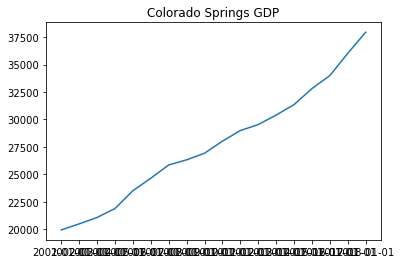

In [296]:
plt.plot(cos_gdp)
plt.title('Colorado Springs GDP');

In [298]:
co_unemp['Date']=pd.to_datetime(co_unemp['date'])
co_unemp['Date']

0     2006-01-01
1     2006-02-01
2     2006-03-01
3     2006-04-01
4     2006-05-01
         ...    
163   2019-08-01
164   2019-09-01
165   2019-10-01
166   2019-11-01
167   2019-12-01
Name: Date, Length: 168, dtype: datetime64[ns]

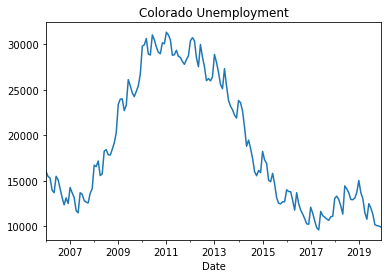

In [300]:
co_unemp.set_index(co_unemp['Date'],drop=True,inplace=True)
co_unemp['unemp'].plot()
plt.title('Colorado Unemployment');

In [10]:
# cos_unemp.drop(drop1,axis=True,inplace=True)

In [301]:
#Colorado Springs sales and use tax revenue 
co_sandu=pd.read_csv('./raw data/sandu_cos.csv')

In [12]:
co_sandu.rename(columns={'Unnamed: 0' : 'date', 'Unnamed: 1': 'su_rev'},inplace=True)
co_sandu.set_index(co_sandu['date'],drop=True,inplace=True)
cos_sandu=co_sandu.drop('Date',inplace=True)
cos_sandu

<Figure size 1440x1080 with 0 Axes>

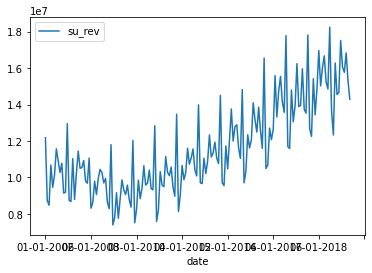

In [13]:
# co_sandu.drop([0],inplace=True)
plt.figure(figsize=(20,15))
co_sandu.astype({'su_rev': 'int32'}).plot()


In [14]:
co_sandu

,date,su_rev
date,,
01-01-2006,01-01-2006,12178334
02-01-2006,02-01-2006,8735598
03-01-2006,03-01-2006,8475104
04-01-2006,04-01-2006,10678617
05-01-2006,05-01-2006,9455838
...,...,...
08-01-2019,08-01-2019,16064102
09-01-2019,09-01-2019,15769154
10-01-2019,10-01-2019,16835541


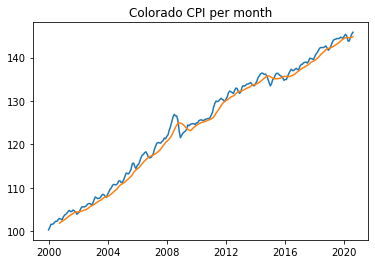

In [15]:
co_cpi=pd.read_csv('./raw data/co_cpi.csv')
co_cpi['Date']=pd.to_datetime(co_cpi['Label'])
co_cpi.set_index(co_cpi['Date'],drop=True,inplace=True)
plt.plot(co_cpi['Value'])
plt.plot(co_cpi['Value'].rolling(10).mean()) ;
plt.title("Colorado CPI per month");

In [16]:
co_cpi.dtypes

Series ID            object
Year                  int64
Period               object
Label                object
Value               float64
Date         datetime64[ns]
dtype: object

In [17]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [18]:
print (f'Colorado Springs CPI stationary {interpret_dftest(adfuller(co_cpi["Value"]))}')
print (f'Colorado Springs S and U stationary {interpret_dftest(adfuller(co_sandu["su_rev"]))}')
print (f'Colorado Springs unemp stationary {interpret_dftest(adfuller(co_unemp["unemp"]))}')


Colorado Springs CPI stationary Test Statistic   -1.121085
p-value           0.706591
dtype: float64
Colorado Springs S and U stationary Test Statistic    0.222573
p-value           0.973500
dtype: float64
Colorado Springs unemp stationary Test Statistic   -2.551636
p-value           0.103411
dtype: float64


In [19]:
df=co_sandu.merge(co_unemp, left_index=True, right_index=True)

In [20]:
df_wk=df.merge(co_cpi,left_index=True, right_index=True)

In [21]:
drop= ['date_x','date_y','Date_x','Year','Period','Label','Date_y','Series ID']

In [22]:
final_df=df_wk.drop(drop,axis=1)

In [23]:
final_df.rename(columns={'Value':'cpi'},inplace=True)

In [24]:
len(final_df)

168

In [25]:
final_df=final_df.astype('float')

In [312]:
final_df.to_csv('final_df.csv',)

In [27]:
final_df['t1']=final_df['su_rev']*final_df['cpi'] #feature engineering: combining revenue and taxes in to one column.
final_df['t2']=final_df['t1']/final_df['unemp'] #feature engineering: divided t1 by unemployment to show the inverse of their movements 

In [311]:
final_df

,su_rev,unemp,cpi,t1,t2
Date,,,,,
2006-01-01,12178334.0,15997.0,115.200,1.402944e+09,87700.448634
2006-02-01,8735598.0,15467.0,115.400,1.008088e+09,65176.699373
2006-03-01,8475104.0,15301.0,116.000,9.831121e+08,64251.491014
2006-04-01,10678617.0,13971.0,116.900,1.248330e+09,89351.537277
2006-05-01,9455838.0,13690.0,117.500,1.111061e+09,81158.580351
...,...,...,...,...,...
2019-08-01,16064102.0,11321.0,144.388,2.319464e+09,204881.508663
2019-09-01,15769154.0,10188.0,144.428,2.277507e+09,223548.034346
2019-10-01,16835541.0,10079.0,144.722,2.436473e+09,241737.589503


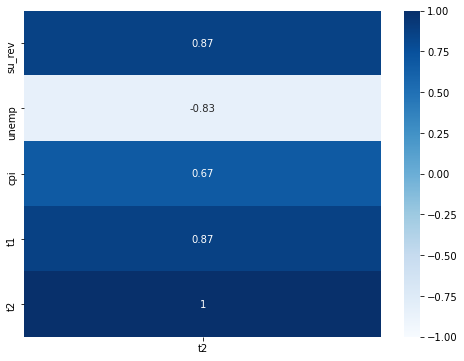

In [313]:
corr = final_df.corr()[['t2']]
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap="Blues", annot=True, vmin=-1, vmax=1);

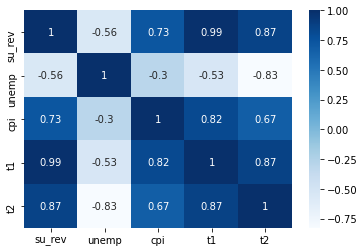

In [31]:
sns.heatmap(final_df.corr(),cmap="Blues",annot=True)

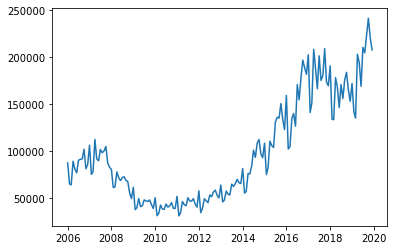

In [32]:
plt.plot(final_df['t2']) #this shows how fast an economy can grow when unemployment is reduced. It shows the exponential growth of human ingenuity.But what is the stronger puller? unemployment was strong enough to pull down the multiplied power of gov't revenue and cpi.   

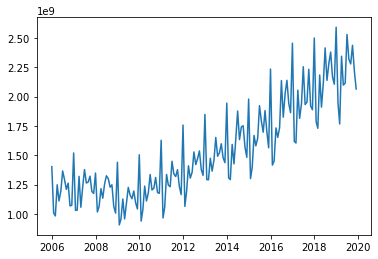

In [33]:
plt.plot(final_df['t1']) #this juxtposition from the plot above may be confusing. Yes the plot shows that revenue increased from 2008 and beyond. but the exponential increase is hard to ignore. Again, this displays the exponential power of the human mind and economic growth when it's released. 

In [34]:
train, test = train_test_split(final_df,
                               test_size = 0.25,
                              shuffle = False)

In [35]:
model=VAR(train)

C:\Users\natha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [250]:
model

In [251]:
ts_model = model.fit(maxlags=10,  #what is this actually doing? 
                    ic='aic' )

In [252]:
ts_model.k_ar #Finding the number of lags before information is not longer relevant  

10

In [253]:
# ts_model

In [254]:
train.tail()

,su_rev,unemp,cpi,t1,t2
Date,,,,,
2016-02-01,10490529.0,13821.0,134.953,1.415728e+09,102433.135094
2016-03-01,10688559.0,13802.0,135.655,1.449956e+09,105054.084274
2016-04-01,12710215.0,12854.0,136.332,1.732809e+09,134806.988593
2016-05-01,12069433.0,11779.0,136.895,1.652245e+09,140270.399061
2016-06-01,12641363.0,13700.0,137.329,1.736026e+09,126717.207257


In [255]:
ts_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 11, Oct, 2020
Time:                     17:29:36
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    92.7450
Nobs:                     116.000    HQIC:                   89.1490
Log likelihood:          -5596.11    FPE:                6.15735e+37
AIC:                      86.6918    Det(Omega_mle):     9.95638e+36
--------------------------------------------------------------------
Results for equation su_rev
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const       -9972378.553350  46007219.931663           -0.217           0.828
L1.su_rev         -1.033533         1.409500           -0.733           0.463
L1.unemp        -366.172215       138.180651           -2.650          

In [268]:
ts_model.forecast(test.values,30)

array([[1.99359662e+07, 1.39273208e+04, 1.45129795e+02, 2.77839854e+09,
        2.65059103e+05],
       [1.36811126e+07, 1.35599664e+04, 1.47334032e+02, 1.93472395e+09,
        2.10029607e+05],
       [1.45511407e+07, 1.32966038e+04, 1.48794326e+02, 2.10588517e+09,
        2.08830479e+05],
       [1.82362240e+07, 1.10049540e+04, 1.50089151e+02, 2.59451922e+09,
        2.61682623e+05],
       [1.59126080e+07, 8.78107687e+03, 1.50333763e+02, 2.28542473e+09,
        2.63420684e+05],
       [1.71369916e+07, 1.15263145e+04, 1.50955521e+02, 2.45977192e+09,
        2.49861794e+05],
       [1.99821920e+07, 1.11818050e+04, 1.50548514e+02, 2.86142191e+09,
        3.01705913e+05],
       [1.92852842e+07, 9.83406608e+03, 1.50576659e+02, 2.72792187e+09,
        2.97349091e+05],
       [1.91769408e+07, 8.10244837e+03, 1.50452498e+02, 2.74146073e+09,
        3.13170984e+05],
       [2.15201556e+07, 8.80332873e+03, 1.51025550e+02, 3.05770256e+09,
        3.35609763e+05],
       [1.81153824e+07, 8.6531

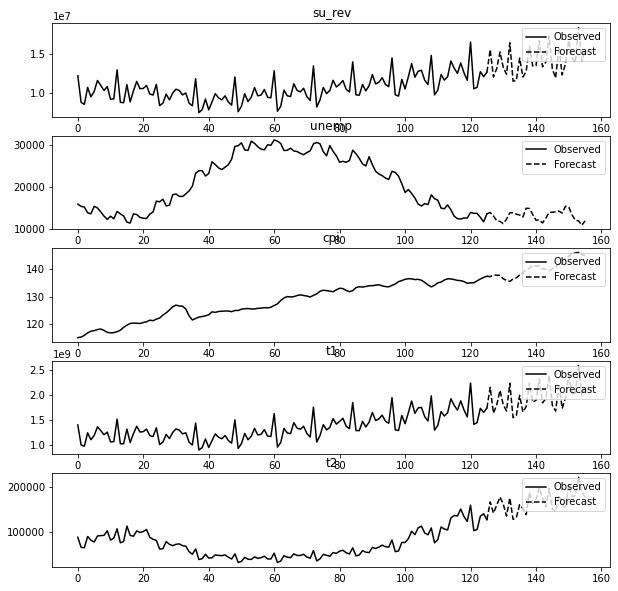

In [270]:
ts_model.plot_forecast(30,plot_stderr=False); # why is it not smoothing into the mean?

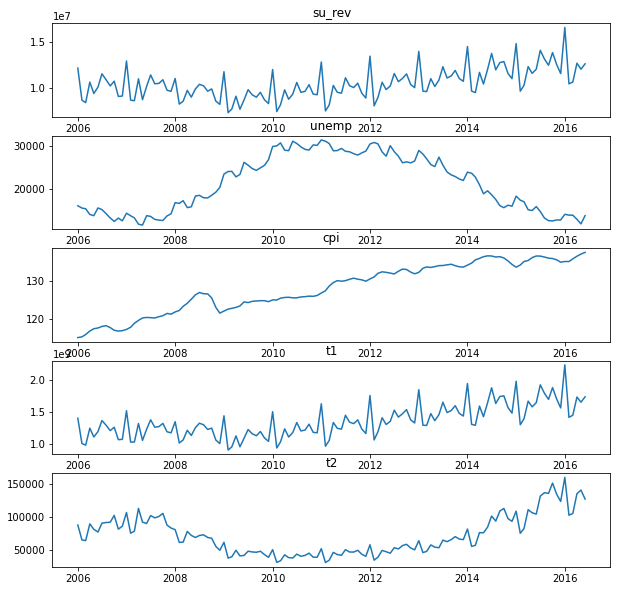

In [46]:
ts_model

In [316]:
# us_gdp=pd.read_csv('./raw data/GDPDEF.csv',index_col='DATE')
df=pd.read_csv('./raw data/GDP1.csv', index_col='DATE')


In [317]:
df.head()

,GDP
DATE,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742


In [327]:
import datetime as dt
import pandas as pd
import requests 
import json

# date = dt.date.today()

# import plotly.graph_objects as go



In [318]:
df

,GDP
DATE,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742
...,...
2019-04-01,21329.877
2019-07-01,21540.325
2019-10-01,21747.394


In [321]:
df['open']=df['GDP'].shift(3)
df['close']=df['GDP']
df.drop('GDP',axis=1,inplace=True)
df['high']=df['close'].shift(2)
df['low']=df['close'].shift(1)
df

,High,Low,open,close,high,low
DATE,,,,,,
1947-01-01,NaN,NaN,NaN,243.164,NaN,NaN
1947-04-01,243.164,243.164,NaN,245.968,NaN,243.164
1947-07-01,245.968,243.164,NaN,249.585,243.164,245.968
1947-10-01,249.585,245.968,243.164,259.745,245.968,249.585
1948-01-01,259.745,249.585,245.968,265.742,249.585,259.745
...,...,...,...,...,...,...
2019-04-01,21115.309,20909.853,20742.723,21329.877,20909.853,21115.309
2019-07-01,21329.877,21115.309,20909.853,21540.325,21115.309,21329.877
2019-10-01,21540.325,21329.877,21115.309,21747.394,21329.877,21540.325


In [51]:
df.head()

,open,close,high,low
DATE,,,,
1947-01-01,NaN,243.164,NaN,NaN
1947-04-01,NaN,245.968,NaN,243.164
1947-07-01,NaN,249.585,243.164,245.968
1947-10-01,243.164,259.745,245.968,249.585
1948-01-01,245.968,265.742,249.585,259.745


In [326]:
new_df['open']=new_df['GDP'].shift(3)
new_df['close']=new_df['GDP']
new_df.drop('GDP',axis=1,inplace=True)
new_df['high']=new_df['close'].shift(2)
new_df['low']=new_df['close'].shift(1)
new_df

,GDP,open,close,high,low
Date,,,,,
2020-10-09,27405.0,NaN,27405.0,NaN,NaN
2020-10-09,27648.1,NaN,27648.1,NaN,27405.0
2020-10-09,27853.3,NaN,27853.3,27405.0,27648.1
2020-10-09,28065.8,27405.0,28065.8,27648.1,27853.3
2020-10-09,28327.9,27648.1,28327.9,27853.3,28065.8
...,...,...,...,...,...
2020-10-09,34304.5,33946.9,34304.5,34021.1,34169.6
2020-10-09,34494.2,34021.1,34494.2,34169.6,34304.5
2020-10-09,34611.8,34169.6,34611.8,34304.5,34494.2


In [53]:
high=[]
low=[]
for a,b in zip(us_gdp['high'], us_gdp['low']): 
    if a < b:
        low.append(a)
    else:
        low.append(b)
#     if a<b:
#         low.append(b)
#     else:
#         low.append(a)

NameError: name 'us_gdp' is not defined

In [56]:
df.head()

,open,close,high,low
DATE,,,,
1947-01-01,NaN,243.164,NaN,NaN
1947-04-01,NaN,245.968,NaN,243.164
1947-07-01,NaN,249.585,243.164,245.968
1947-10-01,243.164,259.745,245.968,249.585
1948-01-01,245.968,265.742,249.585,259.745


In [57]:
# low_df

,GDP,High,Low
DATE,,,
1947-01-01,243.164,NaN,NaN
1947-04-01,245.968,243.164,243.164
1947-07-01,249.585,245.968,243.164
1947-10-01,259.745,249.585,245.968
1948-01-01,265.742,259.745,249.585
1948-04-01,272.567,265.742,259.745
1948-07-01,279.196,272.567,265.742
1948-10-01,280.366,279.196,272.567
1949-01-01,275.034,280.366,279.196


In [320]:
us_gdp['High']=high

NameError: name 'us_gdp' is not defined

In [ ]:
us_gdp['Low']=low

In [ ]:
us_gdp.head(14)

In [59]:
df.drop(['high','low'],axis=1,inplace=True)

In [60]:
df.fillna(0,inplace=True)

In [61]:
df1=df.astype(float)

In [90]:
df

,open,close,High,Low
DATE,,,,
1947-01-01,0.000,243.164,0.000,0.000
1947-04-01,0.000,245.968,243.164,243.164
1947-07-01,0.000,249.585,245.968,243.164
1947-10-01,243.164,259.745,249.585,245.968
1948-01-01,245.968,265.742,259.745,249.585
...,...,...,...,...
2019-04-01,20742.723,21329.877,21115.309,20909.853
2019-07-01,20909.853,21540.325,21329.877,21115.309
2019-10-01,21115.309,21747.394,21540.325,21329.877


In [ ]:
us_gdp.fillna('0.',inplace=True)

In [ ]:
array_close = np.array(us_gdp['close'])
array_open = np.array(us_gdp['open'])
array_high = np.array(us_gdp['High'])
array_low = np.array(us_gdp['Low'])

In [62]:
array_close = np.array(df1['close'])
array_open = np.array(df1['open'])
array_high = np.array(df1['High'])
array_low = np.array(df1['Low'])
# df['date'] = pd.to_datetime(df['date'],unit='s').dt.date
# array_date = np.array(df['date'])

In [63]:
df1.dtypes

open     float64
close    float64
High     float64
Low      float64
dtype: object

In [291]:
#Finding the highest values in a 14 period of ts_model
y=0
z=0
# kperiods are 14 array start from 0 index
kperiods=4
array_highest=[]
for x in range(0,array_high.size-kperiods):
    z=array_high[y]
    for j in range(0,kperiods):
        if(z<array_high[y+1]):
            z=array_high[y+1]
        y=y+1
    # creating list highest of k periods
    array_highest.append(z)
  # skip one from starting after each iteration
    y=y-(kperiods-1)
print("Highest array size",len(array_highest))
# print(array_highest)

Highest array size 290


In [292]:
# Finding the lowest values in a 14 period of ts_model
y=0
z=0
array_lowest=[]
for x in range(0,array_low.size-kperiods):
    z=array_low[y]
    for j in range(0,kperiods):
        if(z>array_low[y+1]):
            z=array_low[y+1]
        y=y+1
    # creating list lowest of k periods
    array_lowest.append(z)
  # skip one from starting after each iteration
    y=y-(kperiods-1)
print("Lowest array size",len(array_lowest))
# print(array_lowest)

Lowest array size 290


In [293]:
# Finding %K
Kvalue=[]
for x in range(kperiods,array_close.size):
    k = ((array_close[x]-array_lowest[x-kperiods])*100/(array_highest[x-kperiods]-array_lowest[x-kperiods]))
    Kvalue.append(k)
print(len(Kvalue))
# print(Kvalue)

290


In [290]:
y=0
# dperiods for calculate d values
dperiods=2
Dvalue=[0,0]
mean=0
for x in range(0,len(Kvalue)-dperiods+1):
    sum=0
    for j in range(0,dperiods):
        sum=Kvalue[y]+sum
        y=y+1
    mean=sum/dperiods
    # d values for %d line adding in the list Dvalue
    Dvalue.append(mean)
  # skip one from starting after each iteration
    y=y-(dperiods-1)
print(len(Dvalue))
# print(Dvalue)

291


Text(0.5, 1.0, 'Stochastic Oscillator')

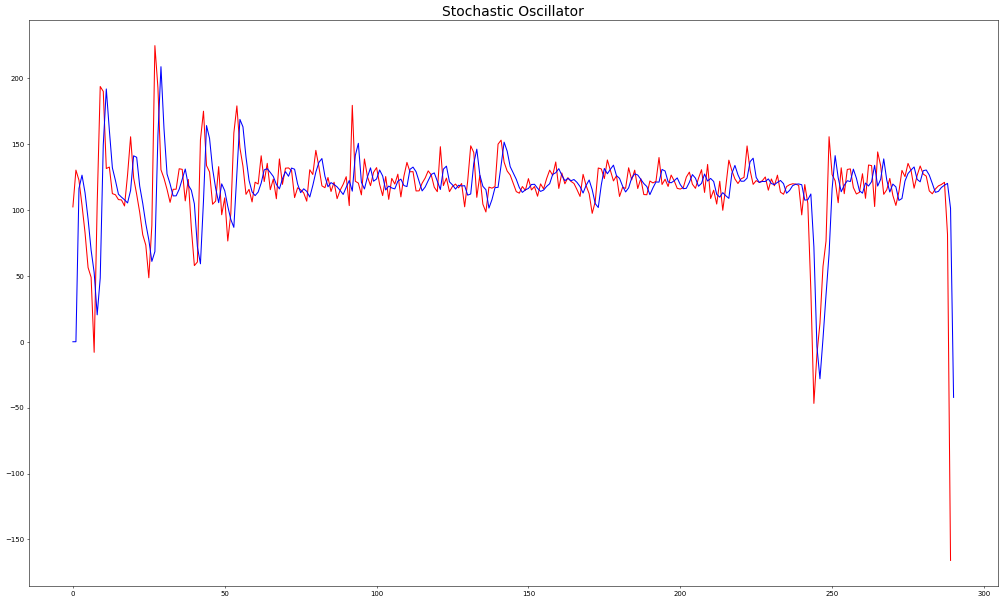

In [283]:
# Visualising the result
plt.figure(figsize=(25,15), dpi=50, facecolor='w', edgecolor='k')
ax = plt.gca() 
plt.plot(Kvalue,color='red',label = '%K line')
plt.plot(Dvalue,color='blue',label = '%D line')
plt.title('Stochastic Oscillator', fontsize=20)
# plt.hlines(135,xmin=min(Kvalue),xmax=max(Kvalue))
# df['date'] = df.index()
# x=df['date']
# labels = array_date
# plt.xticks(labels=labels, rotation = 'vertical')
# for tick in ax.xaxis.get_major_ticks():
#     tick.label1.set_fontsize(10)
# for tick in ax.yaxis.get_major_ticks():
#     tick.label1.set_fontsize(10)
# plt.ylabel('KD_Values', fontsize=20)
# plt.xlabel('Dates', fontsize=15)
# plt.legend()
# plt.show()

In [294]:
# # Visualising the result
# plt.figure(figsize=(25,15), dpi=50, facecolor='w', edgecolor='k')
# ax = plt.gca() 
# plt.plot(b,color='red',label = '%K line')
# plt.plot(y,color='blue',label = '%D line')
# plt.title('Stochastic Oscillator', fontsize=20)
# # df['date'] = df.index()
# # x=df['date']
# labels = array_date
# plt.xticks(labels=labels, rotation = 'vertical')
# for tick in ax.xaxis.get_major_ticks():
#     tick.label1.set_fontsize(10)
# for tick in ax.yaxis.get_major_ticks():
#     tick.label1.set_fontsize(10)
# plt.ylabel('KD_Values', fontsize=20)
# plt.xlabel('Dates', fontsize=15)
# plt.legend()
# plt.show()

In [ ]:
df['date']=df.index

In [ ]:
type(array_date)

In [238]:
import pandas as pd
import numpy as np
from pandas_datareader import data as web
import matplotlib.pyplot as plt
%matplotlib inline

def get_stock(stock,start,end):
    return web.DataReader(stock,'google',start,end)['Close']

def get_high(stock,start,end):
    return web.DataReader(stock,'google',start,end)['High']

def get_low(stock,start,end):
    return web.DataReader(stock,'',start,end)['Low']

def STOK(close, low, high, n): 
    STOK = ((close - pd.rolling_min(low, n)) / (pd.rolling_max(high, n) - pd.rolling_min(low, n))) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - pd.rolling_min(low, n)) / (pd.rolling_max(high, n) - pd.rolling_min(low, n))) * 100
    STOD = pd.rolling_mean(STOK, 3)
    return STOD

df = pd.DataFrame(get_stock('FB', '1/1/2016', '12/31/2016'))
df['High'] = get_high('FB', '1/1/2016', '12/31/2016')
df['Low'] = get_low('FB', '1/1/2016', '12/31/2016')
df['%K'] = STOK(df['Close'], df['Low'], df['High'], 14)
df['%D'] = STOD(df['Close'], df['Low'], df['High'], 14)
df.tail()

NotImplementedError: data_source='GOOGL' is not implemented

In [ ]:
# us_gdp=pd.read_csv('./raw data/GDPDEF.csv',index_col='DATE')



In [99]:
array_close[11]

270.627

In [73]:
array_low[10]

271.351

In [74]:
array_high[10]

275.034

In [97]:
array_lowest[11-kperiods]

271.351

In [98]:
array_lowest[11]

270.627

In [105]:
array_highest[1]

319.945

In [100]:
array_highest[11-kperiods]

280.366

In [71]:
# for x in range(kperiods,array_close.size):
#     print(x)

In [68]:
range(array_close.size)

range(0, 294)

In [95]:
k = ((array_close[11]-array_lowest[11-4])/(array_highest[11-4]-array_lowest[11-4]))


In [96]:
k

-0.08031059345535115

In [94]:
# array_highest

In [93]:
# array_lowest

In [289]:
print(f'Kvalue the last four fiscal quarters {Kvalue[-4::]}')
print(f'Dvalue the last four fiscal quarters {Dvalue[-4::]}')

Kvalue the last four fiscal quarters [119.34865794704608, 120.96536097003862, 81.4610952242076, -165.9308618921342]
Dvalue the last four fiscal quarters [118.78668846682422, 120.15700945854235, 101.2132280971231, -42.2348833339633]


In [279]:
# df2=pd.DataFrame(Dvalue)

In [281]:
# df['kvalue']=Kvalue

In [284]:
df2

,0
0,0.000000
1,0.000000
2,116.268672
3,126.386930
4,113.033223
...,...
286,117.059968
287,118.786688
288,120.157009
289,101.213228
